# Libraries


In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import networkx as nx  
from itertools import combinations

# DataSet

In [81]:
df = pd.read_csv("bread basket.csv")
df

,Transaction,Item,date_time,period_day,weekday_weekend
0,1,Bread,30-10-2016 09:58,morning,weekend
1,2,Scandinavian,30-10-2016 10:05,morning,weekend
2,2,Scandinavian,30-10-2016 10:05,morning,weekend
3,3,Hot chocolate,30-10-2016 10:07,morning,weekend
4,3,Jam,30-10-2016 10:07,morning,weekend
...,...,...,...,...,...
20502,9682,Coffee,09-04-2017 14:32,afternoon,weekend
20503,9682,Tea,09-04-2017 14:32,afternoon,weekend
20504,9683,Coffee,09-04-2017 14:57,afternoon,weekend
20505,9683,Pastry,09-04-2017 14:57,afternoon,weekend


In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20507 entries, 0 to 20506
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Transaction      20507 non-null  int64 
 1   Item             20507 non-null  object
 2   date_time        20507 non-null  object
 3   period_day       20507 non-null  object
 4   weekday_weekend  20507 non-null  object
dtypes: int64(1), object(4)
memory usage: 801.2+ KB


# Date Cleaning

In [83]:
#If Item column sometimes contains separators like ';' replace with ',' to handle inconsistent separators
df['Item'] = df['Item'].astype(str).str.replace(';', ',')  
#Remove stray unicode non-breaking spaces
df['Item'] = df['Item'].str.replace('\u00A0', ' ')
#Normalize whitespace, lower, strip
df['Item'] = df['Item'].astype(str).str.strip().str.lower()
#Remove obvious placeholders
df = df[~df['Item'].isin(['none', 'nan', '', 'nan ', 'none ', 'none.'])]

In [84]:
missing_dates = df['date_time'].isna().sum()
print(f"Rows with invalid/missing date_time: {missing_dates}")

Rows with invalid/missing date_time: 0


In [85]:
df['date_time'] = pd.to_datetime(df['date_time'])
df.head()

C:\Users\Maryam\AppData\Local\Temp\ipykernel_21192\1570395174.py:1: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['date_time'] = pd.to_datetime(df['date_time'])


,Transaction,Item,date_time,period_day,weekday_weekend
0,1,bread,2016-10-30 09:58:00,morning,weekend
1,2,scandinavian,2016-10-30 10:05:00,morning,weekend
2,2,scandinavian,2016-10-30 10:05:00,morning,weekend
3,3,hot chocolate,2016-10-30 10:07:00,morning,weekend
4,3,jam,2016-10-30 10:07:00,morning,weekend


In [86]:
# Extracting date
df['date'] = df['date_time'].dt.date

#Extracting time
df['time'] = df['date_time'].dt.time

# Extracting month and replacing it with text
df['month'] = df['date_time'].dt.month
df['month'] = df['month'].replace((1,2,3,4,5,6,7,8,9,10,11,12), 
                                          ('January','February','March','April','May','June','July','August',
                                          'September','October','November','December'))

# Extracting hour
df['hour'] = df['date_time'].dt.hour
# Replacing hours with text
hour_in_num = (1,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23)
hour_in_obj = ('1-2','7-8','8-9','9-10','10-11','11-12','12-13','13-14','14-15',
               '15-16','16-17','17-18','18-19','19-20','20-21','21-22','22-23','23-24')
df['hour'] = df['hour'].replace(hour_in_num, hour_in_obj)

# Extracting weekday and replacing it with text
df['weekday'] = df['date_time'].dt.weekday
df['weekday'] = df['weekday'].replace((0,1,2,3,4,5,6), 
                                          ('Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'))

# dropping date_time column
df.drop('date_time', axis = 1, inplace = True)

df


,Transaction,Item,period_day,weekday_weekend,date,time,month,hour,weekday
0,1,bread,morning,weekend,2016-10-30,09:58:00,October,9-10,Sunday
1,2,scandinavian,morning,weekend,2016-10-30,10:05:00,October,10-11,Sunday
2,2,scandinavian,morning,weekend,2016-10-30,10:05:00,October,10-11,Sunday
3,3,hot chocolate,morning,weekend,2016-10-30,10:07:00,October,10-11,Sunday
4,3,jam,morning,weekend,2016-10-30,10:07:00,October,10-11,Sunday
...,...,...,...,...,...,...,...,...,...
20502,9682,coffee,afternoon,weekend,2017-04-09,14:32:00,April,14-15,Sunday
20503,9682,tea,afternoon,weekend,2017-04-09,14:32:00,April,14-15,Sunday
20504,9683,coffee,afternoon,weekend,2017-04-09,14:57:00,April,14-15,Sunday
20505,9683,pastry,afternoon,weekend,2017-04-09,14:57:00,April,14-15,Sunday


In [87]:
print(df.duplicated().sum())

1620


In [ ]:
df = df.drop_duplicates(subset=['Transaction', 'Item', 'date'], keep='first')
df

,Transaction,Item,period_day,weekday_weekend,date,time,month,hour,weekday
0,1,bread,morning,weekend,2016-10-30,09:58:00,October,9-10,Sunday
1,2,scandinavian,morning,weekend,2016-10-30,10:05:00,October,10-11,Sunday
3,3,hot chocolate,morning,weekend,2016-10-30,10:07:00,October,10-11,Sunday
4,3,jam,morning,weekend,2016-10-30,10:07:00,October,10-11,Sunday
5,3,cookies,morning,weekend,2016-10-30,10:07:00,October,10-11,Sunday
...,...,...,...,...,...,...,...,...,...
20502,9682,coffee,afternoon,weekend,2017-04-09,14:32:00,April,14-15,Sunday
20503,9682,tea,afternoon,weekend,2017-04-09,14:32:00,April,14-15,Sunday
20504,9683,coffee,afternoon,weekend,2017-04-09,14:57:00,April,14-15,Sunday
20505,9683,pastry,afternoon,weekend,2017-04-09,14:57:00,April,14-15,Sunday


# Group items by Transaction ID

In [56]:
transactions = df.groupby('Transaction')['Item'].apply(list).reset_index(name='items_list')
transactions.to_csv("transactions.csv", index=False)
transactions


,Transaction,items_list
0,1,[bread]
1,2,[scandinavian]
2,3,"[hot chocolate, jam, cookies]"
3,4,[muffin]
4,5,"[coffee, pastry, bread]"
...,...,...
9460,9680,[bread]
9461,9681,"[truffles, tea, spanish brunch, christmas common]"
9462,9682,"[muffin, tacos/fajita, coffee, tea]"
9463,9683,"[coffee, pastry]"


# TransactionEncoder -> One-hot basket

In [89]:
te = TransactionEncoder()
te_array = te.fit(transactions['items_list']).transform(transactions['items_list'])
basket = pd.DataFrame(te_array, columns=te.columns_)
#Save basket matrix
basket.to_csv("basket.csv", index=False)
print("Basket (one-hot) shape:", basket.shape)
basket.head()

Basket (one-hot) shape: (9465, 94)


,adjustment,afternoon with the baker,alfajores,argentina night,art tray,bacon,baguette,bakewell,bare popcorn,basket,...,the bart,the nomad,tiffin,toast,truffles,tshirt,valentine's card,vegan feast,vegan mincepie,victorian sponge
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


# Find frequent itemsets by Apriori

In [58]:
def custom_apriori(df, min_support, use_colnames=False, max_len=None, verbose=0):

    X = df.values.astype(bool)
    n_rows = X.shape[0]
    n_cols = X.shape[1]
    
    # Calculate support for single items
    support_dict = {}
    itemset_dict = {}
    
    # Level 1: Single items
    support_series = np.sum(X, axis=0) / n_rows
    col_indices = np.arange(n_cols, dtype=np.int32)
    
    # Filter by minimum support
    mask = support_series >= min_support
    itemset_dict[1] = col_indices[mask].reshape(-1, 1)
    support_dict[1] = support_series[mask]
    
    if verbose >= 1:
        print(f"Level 1: Found {len(support_dict[1])} frequent 1-itemsets")
    
    max_itemset = 1
    
    # Generate larger itemsets
    while max_itemset < (max_len or float('inf')) and len(itemset_dict[max_itemset]) > 0:
        # Generate candidate itemsets of size max_itemset + 1
        candidates = []
        itemsets = itemset_dict[max_itemset]
        
        # Generate combinations
        for combo in combinations(range(len(itemsets)), 2):
            i, j = combo
            itemset_i = itemsets[i].astype(np.int32)
            itemset_j = itemsets[j].astype(np.int32)
            
            # Merge itemsets that differ in only one item
            union = np.union1d(itemset_i, itemset_j).astype(np.int32)
            
            if len(union) == max_itemset + 1:
                # Check if all subsets are frequent
                valid = True
                if max_itemset >= 2:
                    for sub_combo in combinations(union, max_itemset):
                        sub_itemset = np.array(list(sub_combo), dtype=np.int32)
                        found = False
                        for item in itemsets:
                            if np.array_equal(sub_itemset, item.astype(np.int32)):
                                found = True
                                break
                        if not found:
                            valid = False
                            break
                
                # Check if this candidate is already in the list
                if valid:
                    is_duplicate = False
                    for existing_candidate in candidates:
                        if np.array_equal(union, existing_candidate):
                            is_duplicate = True
                            break
                    
                    if not is_duplicate:
                        candidates.append(union)
        
        if len(candidates) == 0:
            break
        
        # Calculate support for candidates
        next_itemset = max_itemset + 1
        support_list = []
        valid_itemsets = []
        
        for candidate in candidates:
            # Convert candidate to int32 to use as index
            candidate_indices = np.asarray(candidate, dtype=np.int32)
            
            # Count transactions containing all items in candidate
            count = np.sum(np.all(X[:, candidate_indices], axis=1))
            sup = count / n_rows
            
            if sup >= min_support:
                support_list.append(sup)
                valid_itemsets.append(candidate_indices)
        
        if len(valid_itemsets) == 0:
            break
        
        itemset_dict[next_itemset] = np.array(valid_itemsets, dtype=object)
        support_dict[next_itemset] = np.array(support_list)
        
        if verbose >= 1:
            print(f"Level {next_itemset}: Found {len(support_dict[next_itemset])} frequent {next_itemset}-itemsets")
        
        max_itemset = next_itemset
    
    # Convert to DataFrame
    all_res = []
    for k in sorted(itemset_dict.keys()):
        support_series_k = pd.Series(support_dict[k])
        
        # Convert to column names if requested
        if use_colnames:
            itemsets_list = []
            for itemset in itemset_dict[k]:
                itemset_names = frozenset([df.columns[int(i)] for i in itemset])
                itemsets_list.append(itemset_names)
        else:
            itemsets_list = [frozenset(itemset) for itemset in itemset_dict[k]]
        
        itemsets_series = pd.Series(itemsets_list, dtype='object')
        
        res = pd.concat([support_series_k, itemsets_series], axis=1)
        all_res.append(res)
    
    res_df = pd.concat(all_res, ignore_index=True)
    res_df.columns = ['support', 'itemsets']
    res_df = res_df.reset_index(drop=True)
    
    return res_df

In [59]:
# Set minimum support threshold
min_support = 0.02

# Use custom Apriori implementation instead of built-in
freq_itemsets = custom_apriori(basket, min_support=min_support, use_colnames=True, verbose=1)

# Sort by support in descending order
freq_itemsets = freq_itemsets.sort_values(by='support', ascending=False).reset_index(drop=True)

# Save to CSV
freq_itemsets.to_csv("freq_itemsets.csv", index=False)




Level 1: Found 19 frequent 1-itemsets
Level 2: Found 14 frequent 2-itemsets


# Generate association rules

In [60]:

def custom_association_rules(freq_itemsets, metric="confidence", min_threshold=0.01):
    
    # Check required columns
    if not all(col in freq_itemsets.columns for col in ['support', 'itemsets']):
        raise ValueError("DataFrame must contain 'support' and 'itemsets' columns")
    
    # Build support dictionary
    support_dict = {}
    for _, row in freq_itemsets.iterrows():
        itemset = frozenset(row['itemsets'])
        support_dict[itemset] = row['support']
    
    # Lists to store results
    antecedents_list = []
    consequents_list = []
    antecedent_support_list = []
    consequent_support_list = []
    support_list = []
    confidence_list = []
    lift_list = []
    
    # Loop through each itemset
    for itemset in support_dict.keys():
        itemset_support = support_dict[itemset]
        
        # Skip single items
        if len(itemset) < 2:
            continue
        
        # Generate all possible antecedent-consequent combinations
        for i in range(1, len(itemset)):
            for antecedent_tuple in combinations(itemset, i):
                antecedent = frozenset(antecedent_tuple)
                consequent = itemset - antecedent
                
                # Check if support exists
                if antecedent not in support_dict or consequent not in support_dict:
                    continue
                
                antecedent_sup = support_dict[antecedent]
                consequent_sup = support_dict[consequent]
                
                # Calculate metrics
                confidence = itemset_support / antecedent_sup if antecedent_sup > 0 else 0
                lift = confidence / consequent_sup if consequent_sup > 0 else 0

                
               
                
                # Select metric for filtering
                if metric == "confidence":
                    metric_value = confidence
                elif metric == "lift":
                    metric_value = lift
                elif metric == "support":
                    metric_value = itemset_support
                else:
                    metric_value = confidence
                
                # Add rule if meets threshold
                if metric_value >= min_threshold:
                    antecedents_list.append(antecedent)
                    consequents_list.append(consequent)
                    antecedent_support_list.append(antecedent_sup)
                    consequent_support_list.append(consequent_sup)
                    support_list.append(itemset_support)
                    confidence_list.append(confidence)
                    lift_list.append(lift)
                    
    
    # Create results DataFrame
    rules_df = pd.DataFrame({
        'antecedents': antecedents_list,
        'consequents': consequents_list,
        'antecedent support': antecedent_support_list,
        'consequent support': consequent_support_list,
        'support': support_list,
        'confidence': confidence_list,
        'lift': lift_list
    })
    
    return rules_df

In [90]:
rules = custom_association_rules(freq_itemsets, metric="confidence", min_threshold=0.01)
#Add readable strings for antecedents/consequents
rules['antecedents_str'] = rules['antecedents'].apply(lambda x: ', '.join(list(x)))
rules['consequents_str'] = rules['consequents'].apply(lambda x: ', '.join(list(x)))

#Sort rules for inspection
rules = rules.sort_values(['confidence','lift','support'], ascending=[False, False, False]).reset_index(drop=True)

#Save rules
rules.to_csv("rules.csv", index=False)
print("Top rules:\n", rules[['antecedents_str','consequents_str','support','confidence','lift']])
rules 

Top rules:
    antecedents_str consequents_str   support  confidence      lift
0            toast          coffee  0.023666    0.704403  1.472431
1        medialuna          coffee  0.035182    0.569231  1.189878
2           pastry          coffee  0.047544    0.552147  1.154168
3            juice          coffee  0.020602    0.534247  1.116750
4         sandwich          coffee  0.038246    0.532353  1.112792
5             cake          coffee  0.054728    0.526958  1.101515
6          cookies          coffee  0.028209    0.518447  1.083723
7    hot chocolate          coffee  0.029583    0.507246  1.060311
8              tea          coffee  0.049868    0.349630  0.730840
9           pastry           bread  0.029160    0.338650  1.034977
10           bread          coffee  0.090016    0.275105  0.575059
11            cake             tea  0.023772    0.228891  1.604781
12            cake           bread  0.023349    0.224822  0.687097
13             tea           bread  0.028104    0.

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,antecedents_str,consequents_str
0,(toast),(coffee),0.033597,0.478394,0.023666,0.704403,1.472431,toast,coffee
1,(medialuna),(coffee),0.061807,0.478394,0.035182,0.569231,1.189878,medialuna,coffee
2,(pastry),(coffee),0.086107,0.478394,0.047544,0.552147,1.154168,pastry,coffee
3,(juice),(coffee),0.038563,0.478394,0.020602,0.534247,1.116750,juice,coffee
4,(sandwich),(coffee),0.071844,0.478394,0.038246,0.532353,1.112792,sandwich,coffee
5,(cake),(coffee),0.103856,0.478394,0.054728,0.526958,1.101515,cake,coffee
6,(cookies),(coffee),0.054411,0.478394,0.028209,0.518447,1.083723,cookies,coffee
7,(hot chocolate),(coffee),0.058320,0.478394,0.029583,0.507246,1.060311,hot chocolate,coffee
8,(tea),(coffee),0.142631,0.478394,0.049868,0.349630,0.730840,tea,coffee
9,(pastry),(bread),0.086107,0.327205,0.029160,0.338650,1.034977,pastry,bread


In [62]:
#display the strongest rules
strong_rules = rules[(rules['confidence'] >= 0.3) & (rules['lift'] >= 1.2)].sort_values('lift', ascending=False)
print("\nStrong rules (confidence>=0.3 and lift>=1.2):")
if strong_rules.empty:
    print("No strong rules found with these thresholds. Try lowering thresholds.")
else:
    display(strong_rules[['antecedents_str','consequents_str','support','confidence','lift']])


Strong rules (confidence>=0.3 and lift>=1.2):


,antecedents_str,consequents_str,support,confidence,lift
0,toast,coffee,0.023666,0.704403,1.472431


# Visualization & Interpreting Results

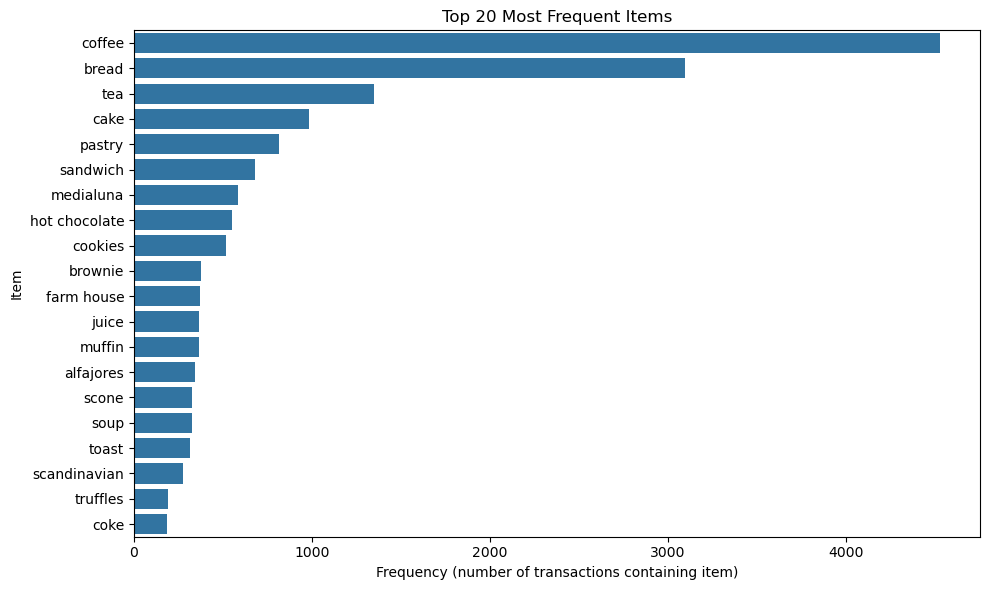

In [63]:
#Top N frequent items
top_n = 20
top_items = basket.sum().sort_values(ascending=False).head(top_n)
plt.figure(figsize=(10,6))
sns.barplot(x=top_items.values, y=top_items.index)
plt.title(f"Top {top_n} Most Frequent Items")
plt.xlabel("Frequency (number of transactions containing item)")
plt.ylabel("Item")
plt.tight_layout()
plt.savefig("project_top_items.png")
plt.show()

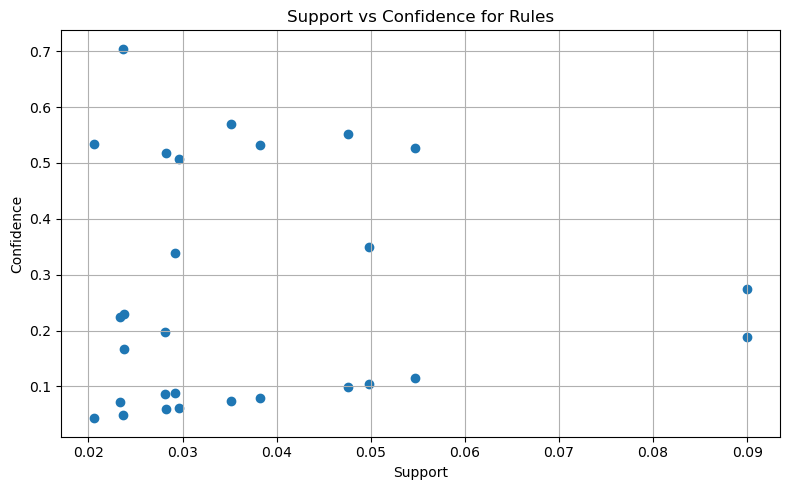

In [64]:
#Support vs Confidence scatter
plt.figure(figsize=(8,5))
plt.scatter(rules['support'], rules['confidence'])
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Support vs Confidence for Rules')
plt.grid(True)
plt.tight_layout()
plt.savefig("project_support_confidence.png")
plt.show()

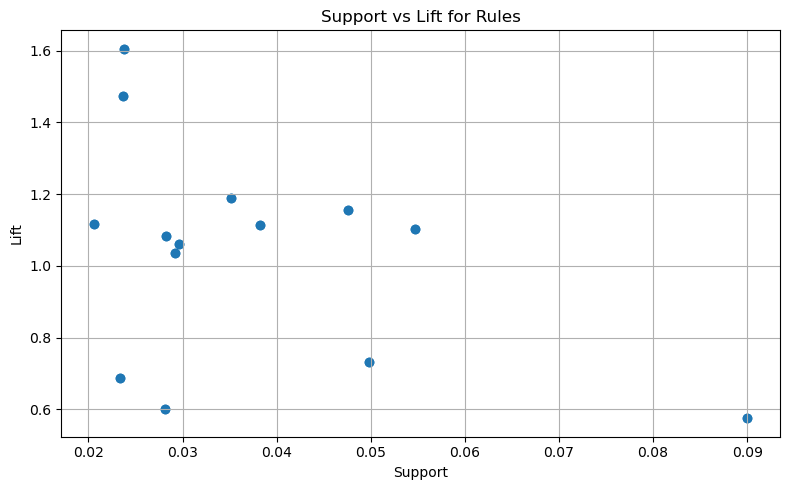

In [65]:
#Support vs Lift scatter
plt.figure(figsize=(8,5))
plt.scatter(rules['support'], rules['lift'])
plt.xlabel('Support')
plt.ylabel('Lift')
plt.title('Support vs Lift for Rules')
plt.grid(True)
plt.tight_layout()
plt.savefig("project_support_lift.png")
plt.show()

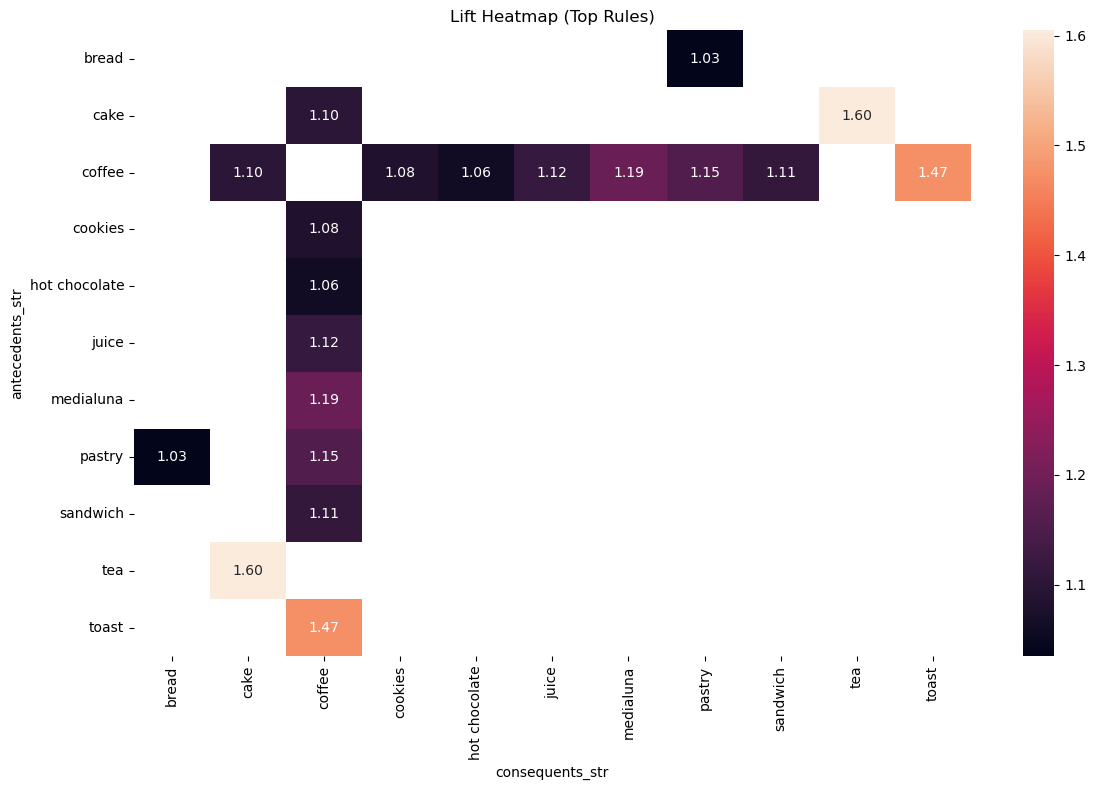

In [66]:
#Heatmap of top rules by lift (pivot antecedent x consequent)
top_rules = rules.sort_values('lift', ascending=False).head(20)
pivot_df = top_rules.pivot_table(values='lift', index='antecedents_str', columns='consequents_str', aggfunc='mean')
plt.figure(figsize=(12,8))
sns.heatmap(pivot_df, annot=True, fmt=".2f")
plt.title('Lift Heatmap (Top Rules)')
plt.tight_layout()
plt.savefig("project_lift_heatmap.png")
plt.show()

C:\Users\Maryam\AppData\Local\Temp\ipykernel_21192\1626065800.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


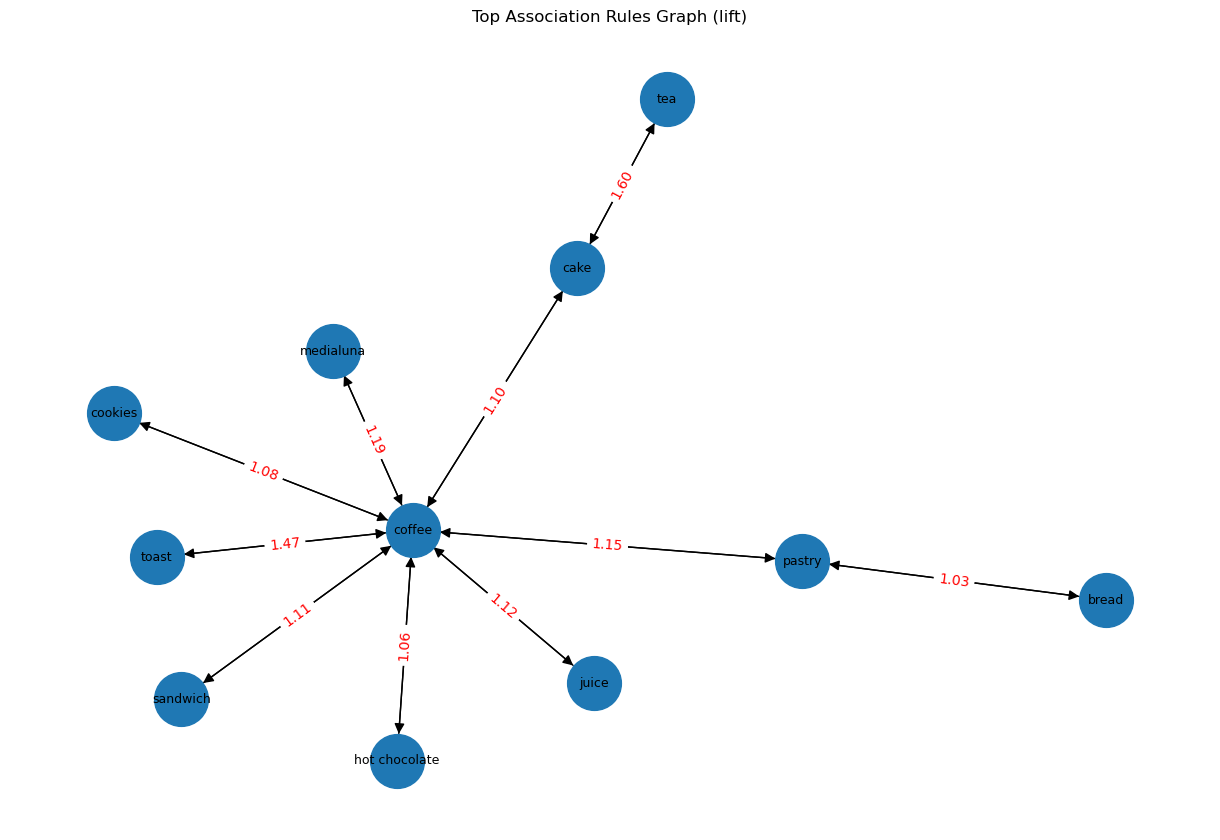

In [67]:
#Graph visualization of top rules (network)
#Build network from top-k rules
k = 20
G = nx.DiGraph()
for _, r in top_rules.head(k).iterrows():
    a = r['antecedents_str']
    b = r['consequents_str']
    w = r['lift']
    G.add_node(a)
    G.add_node(b)
    G.add_edge(a, b, weight=w)

plt.figure(figsize=(12,8))
pos = nx.spring_layout(G, seed=42)
edge_weights = [d['weight'] for (_,_,d) in G.edges(data=True)]
nx.draw(G, pos, with_labels=True, node_size=1500, font_size=9, arrowsize=15)
#draw edge labels (lift)
edge_labels = {(u,v): f"{d['weight']:.2f}" for u,v,d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
plt.title('Top Association Rules Graph (lift)')
plt.tight_layout()
plt.savefig("project_rules_graph.png")
plt.show()